In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import yfinance as yf
from datetime import datetime

In [44]:
import os

path = './figures/BS'

if not os.path.exists(path):
    os.makedirs(path)

In [45]:
# Plotting styling parameters

matplotlib.rcParams['font.family'] = 'serif'

In [46]:
stocks = ['ABG.JO', 'CLS.JO', 'WHL.JO'] # Stock tickers
stock = stocks[2]
data = yf.download(stock)
data = data[data.index <= datetime(2023, 12, 22)] # Cut off on 22 Dec 2023

c:\Users\rofhi\source-code\env\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


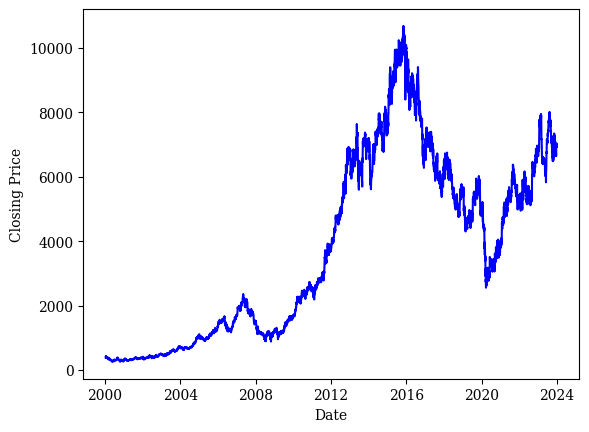

Data ranges from 2000-01-17 00:00:00 to 2023-12-22 00:00:00


In [47]:
plt.plot(data.index, data.get('Close'), c='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.savefig(f'figures/{stock}_chart.svg')
plt.show()

print(f"Data ranges from {data.index[0]} to {data.index[-1]}")

In [48]:
data["Close_L"] = data["Close"].shift(1)

# Drop 'Adj Close' column and NaN columns
data = data.drop("Adj Close", axis=1)
data = data.dropna()

C:\Users\rofhi\AppData\Local\Temp\ipykernel_4220\3697970945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Close_L"] = data["Close"].shift(1)


In [49]:
data['Log_Return'] = np.log(data['Close'] / data['Close_L'])

In [50]:
# Dynamic volatility values
n_years = data.index[-1].year - data.index[0].year
inds = [len(data) // i for i in range(1, n_years + 1)]
inds.append(0)
inds.reverse()

In [51]:
vols = []
for i in range(1, n_years + 1):
    vols.append(data.iloc[inds[i - 1]:inds[i]].get('Log_Return').std())
    # vols.append(0.2)

In [52]:
def simulate_stock_prices(S0, T, r, num_simulations, num_steps):
    """
    Simulate stock prices based on geometric Brownian motion.

    Parameters:
    S0 (float): Initial stock price
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying stock
    num_simulations (int): Number of simulations
    num_steps (int): Number of time steps

    Returns:
    ndarray: Array of simulated stock prices
    """
    dt = T / num_steps
    stock_prices = np.zeros((num_simulations, num_steps + 1))
    stock_prices[:, 0] = S0

    ind = 0
    for i in range(1, num_steps + 1):
        sigma = vols[ind] * 100 # Sigma is multiplied to match amplitude of graph
        if i == inds[ind + 1]:
            ind += 1
            
        Z = np.random.standard_normal(num_simulations)
        stock_prices[:, i] = stock_prices[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    return stock_prices

In [53]:
# Example parameters
S0 = data.iloc[0].get('Close')  # Initial stock price
T = 1  # Time to expiration (in years)
r = 0.05  # Risk-free interest rate
num_simulations = int(32000)  # Number of simulations, make bigger to minimise error
num_steps = len(data) - 1  # Number of trading days (days in data)

In [54]:
# Simulate stock prices
simulated_prices = simulate_stock_prices(S0, T, r, num_simulations, num_steps)

# Monte Carlo-based approach
maes = [mean_absolute_error(data.get('Close'), prices) for prices in simulated_prices]
best = maes.index(min(maes))
best_simulated_prices = simulated_prices[best]

Mean Absolute Error: 966.5670412783261


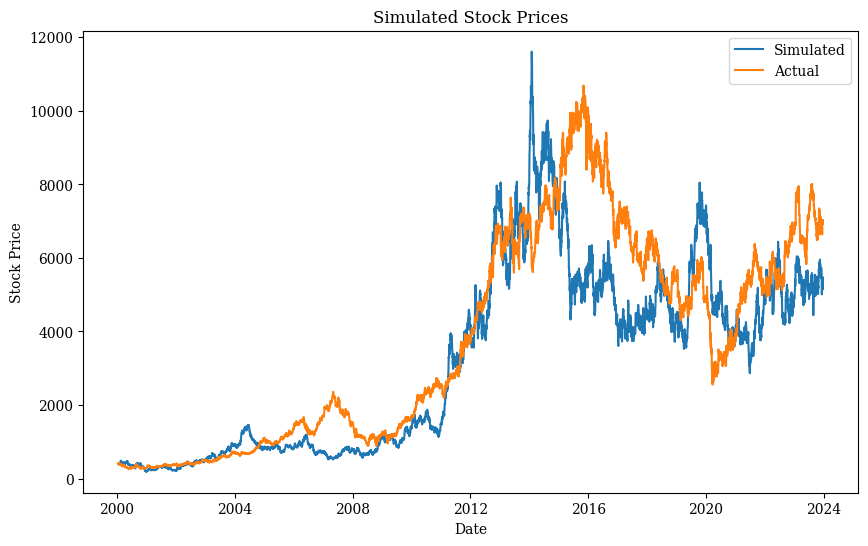

In [55]:
print(f"Mean Absolute Error: {maes[best]}")
# Plot the simulated stock prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, best_simulated_prices.T, label="Simulated")
plt.plot(data.index, data.get('Close'), label='Actual')
plt.title('Simulated Stock Prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.savefig(f'{path}/{num_simulations}_simulations_BS.svg')
plt.show()